In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np

from pprint import pprint
from IPython.display import display
from typing import Dict, Union, List, Callable
from pathlib import Path

import lib.util
import lib.data_preparation
import lib.event_detection

pd.set_option('max_columns', None)

In [2]:
folderpath = Path('data/UAH-DRIVESET-v1/data.parquet/')
df:dd.DataFrame = dd.read_parquet(folderpath)
display(df.head())

,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,timestamp,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed
idx,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20151111132348-25km-D1-DROWSY-MOTORWAY,None,2015-11-11 13:23:48.510,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0.51,0.0,-0.002,-0.067,0.032,-0.002,-0.063,0.030,-1.675,-0.093,-0.172,25km-D1-DROWSY-MOTORWAY,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20151111132348-25km-D1-DROWSY-MOTORWAY,None,2015-11-11 13:23:48.610,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0.61,0.0,-0.066,-0.100,-0.008,-0.026,-0.079,0.016,-1.675,-0.090,-0.173,25km-D1-DROWSY-MOTORWAY,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20151111132348-25km-D1-DROWSY-MOTORWAY,None,2015-11-11 13:23:48.710,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0.71,0.0,0.008,-0.073,-0.007,-0.025,-0.084,0.000,-1.674,-0.080,-0.175,25km-D1-DROWSY-MOTORWAY,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20151111132348-25km-D1-DROWSY-MOTORWAY,None,2015-11-11 13:23:48.810,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0.81,0.0,-0.007,-0.061,0.004,-0.005,-0.069,-0.001,-1.673,-0.073,-0.176,25km-D1-DROWSY-MOTORWAY,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20151111132348-25km-D1-DROWSY-MOTORWAY,None,2015-11-11 13:23:48.920,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0.92,0.0,0.024,-0.047,0.006,0.002,-0.059,0.005,-1.672,-0.070,-0.178,25km-D1-DROWSY-MOTORWAY,NaN


Dask is better with good partionning, which means deciding on a certain size.
Moreover this is a fragment of all the available data, as such I do not need to pursue the investigation with all the data.

In [3]:
trips_memory:pd.Series = df.groupby('trip').apply(
    lambda x: x.memory_usage(deep=True).sum()
).compute()\
.sort_values(ascending=False)

display(trips_memory / 10**6)

trip
25km-D5-DROWSY-MOTORWAY         4.524266
25km-D6-DROWSY-MOTORWAY         4.418209
25km-D4-DROWSY-MOTORWAY         4.255463
26km-D6-NORMAL-MOTORWAY         4.251966
26km-D3-DROWSY-MOTORWAY         4.251395
25km-D4-NORMAL-MOTORWAY         4.164306
25km-D1-DROWSY-MOTORWAY         3.935034
25km-D2-DROWSY-MOTORWAY         3.926156
25km-D4-AGGRESSIVE-MOTORWAY     3.891358
26km-D2-NORMAL-MOTORWAY         3.854337
25km-D5-NORMAL-MOTORWAY         3.841198
26km-D6-AGGRESSIVE-MOTORWAY     3.824677
26km-D3-NORMAL-MOTORWAY         3.762937
26km-D2-AGGRESSIVE-MOTORWAY     3.665688
25km-D1-NORMAL-MOTORWAY         3.624683
26km-D3-AGGRESSIVE-MOTORWAY     3.531563
25km-D5-AGGRESSIVE-MOTORWAY     3.360580
17km-D6-NORMAL-SECONDARY        3.266646
24km-D1-AGGRESSIVE-MOTORWAY     3.078303
16km-D4-NORMAL1-SECONDARY       3.063576
16km-D6-DROWSY-SECONDARY        3.018251
16km-D5-NORMAL1-SECONDARY       2.941183
16km-D3-NORMAL1-SECONDARY       2.940314
16km-D5-DROWSY-SECONDARY        2.938155
17km-D5-NOR

In [4]:
trips_memory.sum() / 10**6

130.724856

In [5]:
# df = df.repartition(partition_size='20MB')
display(df.memory_usage_per_partition(deep=True).compute() / 10**6)

0     6.831239
1     7.151928
2     7.057942
3     7.310651
4     7.406496
5     3.018669
6     7.098140
7     8.340043
8     9.349981
9     6.928017
10    8.593712
11    5.290651
12    9.581147
13    6.097171
14    4.729801
15    7.915103
16    8.439853
17    9.487756
dtype: float64

# Investigation for signal processing, resampling

Text(0.5, 1.0, 'timedelta between samples in seconds')

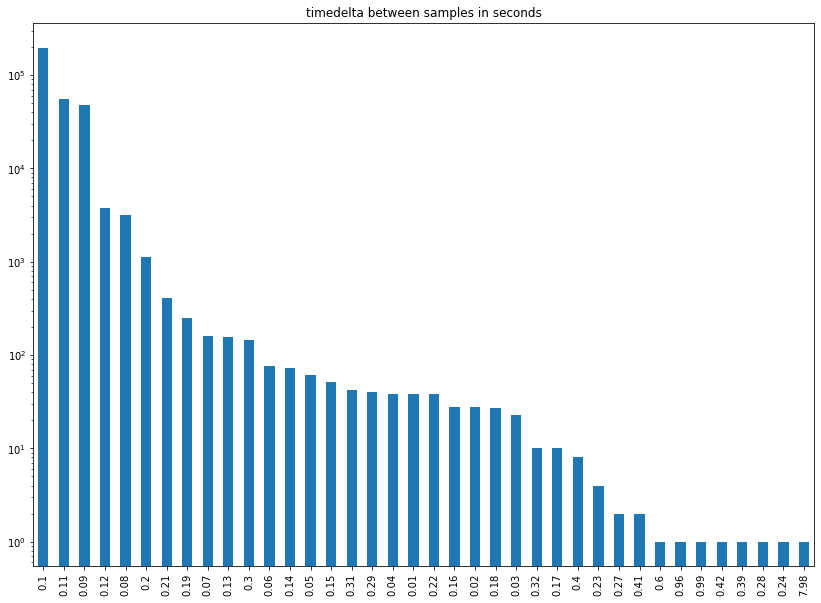

In [6]:
df.groupby('path')['timestamp']\
  .apply(lambda x: x.diff().map(lambda x: x.total_seconds()))\
  .value_counts()\
  .compute()\
  .plot(kind='bar', logy=True, figsize=(14, 10))\
  .set_title('timedelta between samples in seconds')

Timestamp is not uniform at the moment, as such we would like to have a uniform sampling  
Moreover, for all "linear" signal, we would like an interpolation  
We can see that Dask has issue in between partitions...

In [7]:
trip_ids = df['path'].unique().compute()
trip_id = trip_ids[0]

trip_data = df.query(f'path=="{trip_id}"').compute().set_index('timestamp').first('1min')

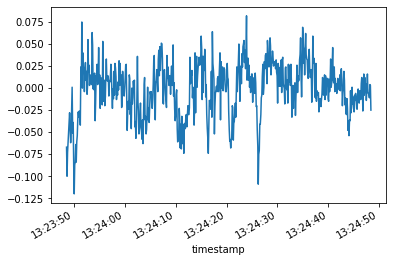

In [8]:
gy = trip_data['gy']
gy.plot();

In [9]:
from scipy.signal import savgol_filter, butter, sosfiltfilt

oidx = gy.index
nidx = pd.date_range(oidx.min(), oidx.max(), freq='100ms')
gy_resample = gy.reindex(oidx.union(nidx)).interpolate('index').reindex(nidx)

gy_interp = gy_resample\
    .interpolate(method='linear', limit=1, limit_area='inside')\
    .interpolate(method='akima', limit_area='inside')\
    .ffill()\
    .bfill()

sos = butter(5, 4, 'low', output='sos', fs=10)

gy_filt = pd.Series(
    sosfiltfilt(sos,gy_interp.to_list()),
    index=gy_interp.index
)

gy_smooth = pd.Series(
    savgol_filter(
        gy_filt.to_list(),
        window_length=5,
        polyorder=2
    ),
    index=gy_interp.index
)

In [10]:
lib.util.plot_multilple_series(
        gy.rename('raw'),
        gy_resample.rename('resample'),
        gy_interp.rename('interpolated'),
        gy_filt.rename('filter'),
        gy_smooth.rename('smooth'),
        title='lateral acceleration through different processing stage'
)

In [11]:
lib.data_preparation.plot_linear(
    trip_data['gx']
)

# Let's calculate the Yaw Rate

In [12]:
ya = trip_data['yaw']

oidx = ya.index
nidx = pd.date_range(oidx.min(), oidx.max(), freq='100ms')
ya_resample = ya.reindex(oidx.union(nidx)).interpolate('index').reindex(nidx)

ya_interp = ya_resample\
    .interpolate(method='linear', limit=1, limit_area='inside')\
    .interpolate(method='akima', limit_area='inside')\
    .ffill()\
    .bfill()

def derivate(x:pd.Series):
    idx = x.index.to_series().diff().dt.total_seconds().fillna(0)
    return pd.Series(np.gradient(x, idx), x.index)

lib.util.plot_multilple_series(
    derivate(ya).rename('raw'),
    derivate(ya_resample).rename('resample'),
    derivate(ya_interp).rename('interpolate'),
    title='yaw rate from different processed yaw angle'
)

The integration step works and the smoothing has no impact on the result.
We will apply integration when necessary after the data preparation with smoothing

# Adaptative Sampling
We will apply piecewise segmentation to the data to compress the sampling rate (while becoming non-uniform)
Doing so for multilple signals and retrieveing all the necessary samples will help us compress the data size (could be useful)
The index list will be added as new column (we will not delete rows for the moment)

In [13]:
cond = lib.data_preparation.adaptative_sampling(gy_smooth)
display(cond[:10])
display(gy_smooth.head())
display(gy_smooth[cond].head())

array([False, False, False, False, False, False, False, False, False,
       False])

2015-11-11 13:23:48.510   -0.074441
2015-11-11 13:23:48.610   -0.082013
2015-11-11 13:23:48.710   -0.079899
2015-11-11 13:23:48.810   -0.060423
2015-11-11 13:23:48.910   -0.047909
Freq: 100L, dtype: float64

2015-11-11 13:23:49.610   -0.013757
2015-11-11 13:23:50.010   -0.105915
2015-11-11 13:23:51.510    0.041870
2015-11-11 13:23:52.510    0.002091
2015-11-11 13:23:53.610    0.046563
dtype: float64

In [14]:
display(lib.data_preparation.plot_segmentation(
    gy_smooth, std_dev=df['gy'].std().compute()))

In [15]:
lib.data_preparation.plot_linear_and_segmentation(
    trip_data['gx'], std_dev=df['gx'].std().compute())

# Data Preparation
So we could see that the preprocessing works:
* smoothing provide minor difference with original data (and erase all noise)
* resampling erase all the hole in the data
* interpolation does not have major difference with resampled

Now we will apply the data processing on all the data with:
* resampling to uniform index/timestamp
* interpolate the values (depend if linear or piecewise signal)
* smooth the data (for some linear)
* integrate and add some channels (such as yaw angle or slip angle)
* get the change-points from the piecewise segmentation algorithm


## Test on a fraction of dataset

In [16]:
dft = df.partitions[0:2].compute()
display(dft.head())

,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,timestamp,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed
idx,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20151111132348-25km-D1-DROWSY-MOTORWAY,None,2015-11-11 13:23:48.510,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0.51,0.0,-0.002,-0.067,0.032,-0.002,-0.063,0.030,-1.675,-0.093,-0.172,25km-D1-DROWSY-MOTORWAY,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20151111132348-25km-D1-DROWSY-MOTORWAY,None,2015-11-11 13:23:48.610,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0.61,0.0,-0.066,-0.100,-0.008,-0.026,-0.079,0.016,-1.675,-0.090,-0.173,25km-D1-DROWSY-MOTORWAY,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20151111132348-25km-D1-DROWSY-MOTORWAY,None,2015-11-11 13:23:48.710,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0.71,0.0,0.008,-0.073,-0.007,-0.025,-0.084,0.000,-1.674,-0.080,-0.175,25km-D1-DROWSY-MOTORWAY,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20151111132348-25km-D1-DROWSY-MOTORWAY,None,2015-11-11 13:23:48.810,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0.81,0.0,-0.007,-0.061,0.004,-0.005,-0.069,-0.001,-1.673,-0.073,-0.176,25km-D1-DROWSY-MOTORWAY,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20151111132348-25km-D1-DROWSY-MOTORWAY,None,2015-11-11 13:23:48.920,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0.92,0.0,0.024,-0.047,0.006,0.002,-0.059,0.005,-1.672,-0.070,-0.178,25km-D1-DROWSY-MOTORWAY,NaN


First we apply signal transformation (resampling and interpolation)
this is thought to be done trip by trip

In [17]:
dft = dft.set_index('timestamp')\
        .groupby('trip')\
        .apply(lib.data_preparation.apply_signal_preparation)\
        .reset_index(drop=True)

display(dft.head())

,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,timestamp
0,25.48,40.584326,-3.552914,611.4,4.0,5.0,99.8,2.109,0.0,0.0,0.0,20151203173103-17km-D4-NORMAL2-SECONDARY,17km-D4-NORMAL2-SECONDARY,56.06,90.0,1.0,primary,2.0,1.0,40.581047,-3.545866,1.665,17km-D4-NORMAL2-SECONDARY,0.81,0.0,0.082382,-0.011209,-0.095,0.018,-0.002,-0.016,-1.505911,0.035323,0.071769,17km-D4-NORMAL2-SECONDARY,80.424215,2015-12-03 17:31:03.810
1,25.48,40.584326,-3.552914,611.4,4.0,5.0,99.8,2.109,0.0,0.0,0.0,20151203173103-17km-D4-NORMAL2-SECONDARY,17km-D4-NORMAL2-SECONDARY,56.06,90.0,1.0,primary,2.0,1.0,40.581047,-3.545866,1.665,17km-D4-NORMAL2-SECONDARY,0.83,0.0,-0.031327,-0.024183,-0.064,-0.083,0.046,-0.065,-1.612075,0.038229,0.079092,17km-D4-NORMAL2-SECONDARY,80.424215,2015-12-03 17:31:03.910
2,25.48,40.584326,-3.552914,611.4,4.0,5.0,99.8,2.109,0.0,0.0,0.0,20151203173103-17km-D4-NORMAL2-SECONDARY,17km-D4-NORMAL2-SECONDARY,56.06,90.0,1.0,primary,2.0,1.0,40.581047,-3.545866,1.665,17km-D4-NORMAL2-SECONDARY,0.93,0.0,-0.077317,-0.030685,0.019,-0.047,-0.047,0.034,-1.671034,0.039964,0.084092,17km-D4-NORMAL2-SECONDARY,80.424215,2015-12-03 17:31:04.010
3,25.48,40.584326,-3.552914,611.4,4.0,5.0,99.8,2.109,0.0,0.0,0.0,20151203173103-17km-D4-NORMAL2-SECONDARY,17km-D4-NORMAL2-SECONDARY,56.06,90.0,1.0,primary,2.0,1.0,40.581047,-3.545866,1.665,17km-D4-NORMAL2-SECONDARY,1.02,0.0,-0.021878,-0.025444,0.044,-0.052,-0.060,0.012,-1.659966,0.039967,0.085749,17km-D4-NORMAL2-SECONDARY,80.424215,2015-12-03 17:31:04.110
4,25.48,40.584326,-3.552914,611.4,4.0,5.0,99.8,2.109,0.0,0.0,0.0,20151203173103-17km-D4-NORMAL2-SECONDARY,17km-D4-NORMAL2-SECONDARY,56.06,90.0,1.0,primary,2.0,1.0,40.581047,-3.545866,1.665,17km-D4-NORMAL2-SECONDARY,1.13,0.0,-0.013878,-0.027598,0.041,-0.061,-0.019,0.050,-1.657986,0.040557,0.087756,17km-D4-NORMAL2-SECONDARY,80.424215,2015-12-03 17:31:04.210


We add the Vehicle Dynamics signals

In [18]:
dft = lib.data_preparation.add_vd_signal(dft)
display(dft.head())

,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,timestamp,yr,beta,vx,vy,curvature,distx,disty,distance
0,25.48,40.584326,-3.552914,611.4,4.0,5.0,99.8,2.109,0.0,0.0,0.0,20151203173103-17km-D4-NORMAL2-SECONDARY,17km-D4-NORMAL2-SECONDARY,56.06,90.0,1.0,primary,2.0,1.0,40.581047,-3.545866,1.665,17km-D4-NORMAL2-SECONDARY,1.449164e+09,0.0,0.808165,-0.109958,-0.93195,0.018,-0.002,-0.016,-1.505911,0.035323,0.071769,17km-D4-NORMAL2-SECONDARY,80.424215,2015-12-03 17:31:03.810,0.073233,-0.138512,22.339995,-0.054007,17478.354596,0.000000,0.000000,0.000000
1,25.48,40.584326,-3.552914,611.4,4.0,5.0,99.8,2.109,0.0,0.0,0.0,20151203173103-17km-D4-NORMAL2-SECONDARY,17km-D4-NORMAL2-SECONDARY,56.06,90.0,1.0,primary,2.0,1.0,40.581047,-3.545866,1.665,17km-D4-NORMAL2-SECONDARY,1.449164e+09,0.0,-0.307319,-0.237240,-0.62784,-0.083,0.046,-0.065,-1.612075,0.038229,0.079092,17km-D4-NORMAL2-SECONDARY,80.424215,2015-12-03 17:31:03.910,0.061617,-0.261265,22.339828,-0.101869,20773.224240,2.234003,-0.004853,2.234009
2,25.48,40.584326,-3.552914,611.4,4.0,5.0,99.8,2.109,0.0,0.0,0.0,20151203173103-17km-D4-NORMAL2-SECONDARY,17km-D4-NORMAL2-SECONDARY,56.06,90.0,1.0,primary,2.0,1.0,40.581047,-3.545866,1.665,17km-D4-NORMAL2-SECONDARY,1.449164e+09,0.0,-0.758481,-0.301018,0.18639,-0.047,-0.047,0.034,-1.671034,0.039964,0.084092,17km-D4-NORMAL2-SECONDARY,80.424215,2015-12-03 17:31:04.010,0.033284,-0.313996,22.339724,-0.122429,38456.130231,2.233989,-0.008034,2.234004
3,25.48,40.584326,-3.552914,611.4,4.0,5.0,99.8,2.109,0.0,0.0,0.0,20151203173103-17km-D4-NORMAL2-SECONDARY,17km-D4-NORMAL2-SECONDARY,56.06,90.0,1.0,primary,2.0,1.0,40.581047,-3.545866,1.665,17km-D4-NORMAL2-SECONDARY,1.449164e+09,0.0,-0.214622,-0.249610,0.43164,-0.052,-0.060,0.012,-1.659966,0.039967,0.085749,17km-D4-NORMAL2-SECONDARY,80.424215,2015-12-03 17:31:04.110,0.018320,-0.256753,22.339836,-0.100110,69867.554859,2.233990,-0.007816,2.234004
4,25.48,40.584326,-3.552914,611.4,4.0,5.0,99.8,2.109,0.0,0.0,0.0,20151203173103-17km-D4-NORMAL2-SECONDARY,17km-D4-NORMAL2-SECONDARY,56.06,90.0,1.0,primary,2.0,1.0,40.581047,-3.545866,1.665,17km-D4-NORMAL2-SECONDARY,1.449164e+09,0.0,-0.136140,-0.270736,0.40221,-0.061,-0.019,0.050,-1.657986,0.040557,0.087756,17km-D4-NORMAL2-SECONDARY,80.424215,2015-12-03 17:31:04.210,0.020954,-0.278906,22.339795,-0.108747,61086.919376,2.233998,-0.007060,2.234009


We add the segmented signal

In [19]:
col_segmentation = ['gx','gy']
std_dev = {k:dft[k].std() for k in col_segmentation}

dft['change_points'] = dft.groupby('trip')[col_segmentation]\
    .transform(lambda x: lib.data_preparation.adaptative_sampling(x, std_dev[x.name]))\
    .any(axis='columns')

In [20]:
display(dft.head())

,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,timestamp,yr,beta,vx,vy,curvature,distx,disty,distance,change_points
0,25.48,40.584326,-3.552914,611.4,4.0,5.0,99.8,2.109,0.0,0.0,0.0,20151203173103-17km-D4-NORMAL2-SECONDARY,17km-D4-NORMAL2-SECONDARY,56.06,90.0,1.0,primary,2.0,1.0,40.581047,-3.545866,1.665,17km-D4-NORMAL2-SECONDARY,1.449164e+09,0.0,0.808165,-0.109958,-0.93195,0.018,-0.002,-0.016,-1.505911,0.035323,0.071769,17km-D4-NORMAL2-SECONDARY,80.424215,2015-12-03 17:31:03.810,0.073233,-0.138512,22.339995,-0.054007,17478.354596,0.000000,0.000000,0.000000,False
1,25.48,40.584326,-3.552914,611.4,4.0,5.0,99.8,2.109,0.0,0.0,0.0,20151203173103-17km-D4-NORMAL2-SECONDARY,17km-D4-NORMAL2-SECONDARY,56.06,90.0,1.0,primary,2.0,1.0,40.581047,-3.545866,1.665,17km-D4-NORMAL2-SECONDARY,1.449164e+09,0.0,-0.307319,-0.237240,-0.62784,-0.083,0.046,-0.065,-1.612075,0.038229,0.079092,17km-D4-NORMAL2-SECONDARY,80.424215,2015-12-03 17:31:03.910,0.061617,-0.261265,22.339828,-0.101869,20773.224240,2.234003,-0.004853,2.234009,False
2,25.48,40.584326,-3.552914,611.4,4.0,5.0,99.8,2.109,0.0,0.0,0.0,20151203173103-17km-D4-NORMAL2-SECONDARY,17km-D4-NORMAL2-SECONDARY,56.06,90.0,1.0,primary,2.0,1.0,40.581047,-3.545866,1.665,17km-D4-NORMAL2-SECONDARY,1.449164e+09,0.0,-0.758481,-0.301018,0.18639,-0.047,-0.047,0.034,-1.671034,0.039964,0.084092,17km-D4-NORMAL2-SECONDARY,80.424215,2015-12-03 17:31:04.010,0.033284,-0.313996,22.339724,-0.122429,38456.130231,2.233989,-0.008034,2.234004,True
3,25.48,40.584326,-3.552914,611.4,4.0,5.0,99.8,2.109,0.0,0.0,0.0,20151203173103-17km-D4-NORMAL2-SECONDARY,17km-D4-NORMAL2-SECONDARY,56.06,90.0,1.0,primary,2.0,1.0,40.581047,-3.545866,1.665,17km-D4-NORMAL2-SECONDARY,1.449164e+09,0.0,-0.214622,-0.249610,0.43164,-0.052,-0.060,0.012,-1.659966,0.039967,0.085749,17km-D4-NORMAL2-SECONDARY,80.424215,2015-12-03 17:31:04.110,0.018320,-0.256753,22.339836,-0.100110,69867.554859,2.233990,-0.007816,2.234004,False
4,25.48,40.584326,-3.552914,611.4,4.0,5.0,99.8,2.109,0.0,0.0,0.0,20151203173103-17km-D4-NORMAL2-SECONDARY,17km-D4-NORMAL2-SECONDARY,56.06,90.0,1.0,primary,2.0,1.0,40.581047,-3.545866,1.665,17km-D4-NORMAL2-SECONDARY,1.449164e+09,0.0,-0.136140,-0.270736,0.40221,-0.061,-0.019,0.050,-1.657986,0.040557,0.087756,17km-D4-NORMAL2-SECONDARY,80.424215,2015-12-03 17:31:04.210,0.020954,-0.278906,22.339795,-0.108747,61086.919376,2.233998,-0.007060,2.234009,True


In [21]:
display(f"{(dft['change_points'].sum() / dft.shape[0]) * 100}% of data is a change point")

'20.80161750713606% of data is a change point'

## Apply on all dataset
Now we apply what we tested on all the data (all partitions)
It seems the previous partitions were too small, so I change the partition size to 20MB instead of 10MB

In [22]:
df = dd.read_parquet(folderpath).repartition(partition_size='20MB')
df = lib.data_preparation.apply_data_preparation(df)

display(df.head())
df.to_parquet(Path(folderpath.parent, 'data_process.parquet'))

,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,timestamp,yr,beta,vx,vy,curvature,distx,disty,distance,change_points
0,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.107936,-0.041451,-0.39240,-0.006,-0.009,-0.022,-1.561743,0.011128,0.097137,12km-D5-AGGRESSIVE-SECONDARY,131.878207,2015-12-11 16:56:19.910,0.004842,-0.044547,36.632824,-0.028482,433436.793932,0.000000,0.000000,0.000000,False
1,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.186017,-0.053898,-0.36297,-0.002,-0.006,-0.034,-1.561573,0.013535,0.097621,12km-D5-AGGRESSIVE-SECONDARY,131.878207,2015-12-11 16:56:20.010,0.005547,-0.057444,36.632817,-0.036728,378370.393667,3.663279,0.002966,3.663280,False
2,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.213286,-0.044389,-0.12753,0.011,-0.010,-0.021,-1.560896,0.015397,0.098246,12km-D5-AGGRESSIVE-SECONDARY,131.878207,2015-12-11 16:56:20.110,0.006464,-0.048522,36.632822,-0.031023,324710.369281,3.663279,0.002874,3.663280,False
3,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.229753,0.008214,-0.40221,0.023,-0.002,-0.031,-1.559989,0.016346,0.098914,12km-D5-AGGRESSIVE-SECONDARY,131.878207,2015-12-11 16:56:20.210,0.008321,0.002894,36.632835,0.001850,252239.921285,3.663285,0.004844,3.663289,False
4,27.95,40.533794,-3.456321,650.5,6.0,5.0,269.6,0.352,0.0,0.0,0.0,20151211165606-12km-D5-AGGRESSIVE-SECONDARY,12km-D5-AGGRESSIVE-SECONDARY,34.87,90.0,1.0,primary,2.0,1.0,40.533775,-3.458919,1.017,12km-D5-AGGRESSIVE-SECONDARY,1.449853e+09,1.0,0.132273,-0.010419,-0.40221,0.023,-0.002,-0.031,-1.557711,0.017944,0.099910,12km-D5-AGGRESSIVE-SECONDARY,131.878207,2015-12-11 16:56:20.310,0.009965,-0.016791,36.632834,-0.010735,210630.254921,3.663275,0.005912,3.663280,False


In [23]:
display(f"{(df['change_points'].sum() / df.shape[0]).compute() * 100}% of data is a change point")

'23.47112063756575% of data is a change point'

## Preparation step flexibility

For other purpose, users can apply a faster data prepration which do not apply the segmentation (huge time gain)
The function is "lib.data_preparation.apply_data_preparation_fast()", then to apply the segmentation the user can either:
* apply its own with: "lib.data_preparation.calculate_change_point()"
* apply standard with: "lib.data_preparation.apply_calculate_change_point()"

# Faster with "map_partitions()"

The data preparation could be refactored with "map_partitions()" instead of "groupby()"

In [10]:
folderpath = Path('data/UAH-DRIVESET-v1/data.parquet/')
df:dd.DataFrame = dd.read_parquet(folderpath)

trips_memory = df.groupby('trip').apply(
    lambda x: x.memory_usage(deep=True).sum()
).compute()\
.sort_values(ascending=False)

display(trips_memory / 10**6)

trip
25km-D5-DROWSY-MOTORWAY         4.524266
25km-D6-DROWSY-MOTORWAY         4.418209
25km-D4-DROWSY-MOTORWAY         4.255463
26km-D6-NORMAL-MOTORWAY         4.251966
26km-D3-DROWSY-MOTORWAY         4.251395
25km-D4-NORMAL-MOTORWAY         4.164306
25km-D1-DROWSY-MOTORWAY         3.935034
25km-D2-DROWSY-MOTORWAY         3.926156
25km-D4-AGGRESSIVE-MOTORWAY     3.891358
26km-D2-NORMAL-MOTORWAY         3.854337
25km-D5-NORMAL-MOTORWAY         3.841198
26km-D6-AGGRESSIVE-MOTORWAY     3.824677
26km-D3-NORMAL-MOTORWAY         3.762937
26km-D2-AGGRESSIVE-MOTORWAY     3.665688
25km-D1-NORMAL-MOTORWAY         3.624683
26km-D3-AGGRESSIVE-MOTORWAY     3.531563
25km-D5-AGGRESSIVE-MOTORWAY     3.360580
17km-D6-NORMAL-SECONDARY        3.266646
24km-D1-AGGRESSIVE-MOTORWAY     3.078303
16km-D4-NORMAL1-SECONDARY       3.063576
16km-D6-DROWSY-SECONDARY        3.018251
16km-D5-NORMAL1-SECONDARY       2.941183
16km-D3-NORMAL1-SECONDARY       2.940314
16km-D5-DROWSY-SECONDARY        2.938155
17km-D5-NOR

There is an issue with an empty trip which should have been taken care of before...

In [3]:
df['trip'] = df['trip'].astype(str)
df = df.query('trip!="None"')
df.trip.unique().compute()

0          25km-D1-DROWSY-MOTORWAY
1        17km-D4-NORMAL2-SECONDARY
2          25km-D1-NORMAL-MOTORWAY
3      26km-D3-AGGRESSIVE-MOTORWAY
4        16km-D3-NORMAL2-SECONDARY
5          26km-D6-NORMAL-MOTORWAY
6        16km-D4-NORMAL1-SECONDARY
7          26km-D3-DROWSY-MOTORWAY
8        17km-D2-NORMAL2-SECONDARY
9          25km-D5-DROWSY-MOTORWAY
10        16km-D6-DROWSY-SECONDARY
11         25km-D4-NORMAL-MOTORWAY
12        16km-D5-DROWSY-SECONDARY
13         25km-D6-DROWSY-MOTORWAY
14         25km-D2-DROWSY-MOTORWAY
15    16km-D2-AGGRESSIVE-SECONDARY
16         25km-D5-NORMAL-MOTORWAY
17       17km-D5-NORMAL2-SECONDARY
18        17km-D6-NORMAL-SECONDARY
19     26km-D2-AGGRESSIVE-MOTORWAY
20        13km-D1-DROWSY-SECONDARY
21       16km-D2-NORMAL1-SECONDARY
22         26km-D3-NORMAL-MOTORWAY
23         26km-D2-NORMAL-MOTORWAY
24        17km-D4-DROWSY-SECONDARY
25     25km-D4-AGGRESSIVE-MOTORWAY
26         25km-D4-DROWSY-MOTORWAY
27       16km-D1-NORMAL2-SECONDARY
28     25km-D5-AGGRE

In [4]:
df = lib.util.repartition_by(df, by='trip')
display(df.memory_usage_per_partition(deep=True).compute() / 10**6)

0     3.108938
1     3.105997
2     3.104054
3     3.354064
4     3.572928
5     2.684756
6     3.726494
7     3.159116
8     3.185670
9     3.227118
10    3.568472
11    3.183994
12    3.175959
13    3.372005
14    3.217566
15    3.099092
16    3.339283
17    3.049680
18    3.680921
19    2.862956
20    3.473094
21    3.343879
22    3.278615
23    3.161803
24    3.037995
25    3.503977
26    3.374439
27    2.936725
28    3.456463
29    3.315668
30    3.098060
31    3.481023
32    3.220919
33    3.116475
34    3.568370
35    3.268421
36    3.294525
37    2.979342
38    3.661339
39    3.374661
dtype: float64

In [5]:
df.head()

,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,timestamp,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed
idx,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20151111132348-25km-D1-DROWSY-MOTORWAY,None,2015-11-11 13:23:48.510,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0.51,0.0,-0.002,-0.067,0.032,-0.002,-0.063,0.030,-1.675,-0.093,-0.172,25km-D1-DROWSY-MOTORWAY,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20151111132348-25km-D1-DROWSY-MOTORWAY,None,2015-11-11 13:23:48.610,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0.61,0.0,-0.066,-0.100,-0.008,-0.026,-0.079,0.016,-1.675,-0.090,-0.173,25km-D1-DROWSY-MOTORWAY,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20151111132348-25km-D1-DROWSY-MOTORWAY,None,2015-11-11 13:23:48.710,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0.71,0.0,0.008,-0.073,-0.007,-0.025,-0.084,0.000,-1.674,-0.080,-0.175,25km-D1-DROWSY-MOTORWAY,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20151111132348-25km-D1-DROWSY-MOTORWAY,None,2015-11-11 13:23:48.810,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0.81,0.0,-0.007,-0.061,0.004,-0.005,-0.069,-0.001,-1.673,-0.073,-0.176,25km-D1-DROWSY-MOTORWAY,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20151111132348-25km-D1-DROWSY-MOTORWAY,None,2015-11-11 13:23:48.920,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0.92,0.0,0.024,-0.047,0.006,0.002,-0.059,0.005,-1.672,-0.070,-0.178,25km-D1-DROWSY-MOTORWAY,NaN


In [6]:
display(f"number of trips: {df['trip'].unique().compute().shape[0]}")
display(f"number of partitions: {df.npartitions}")

'number of trips: 40'

'number of partitions: 40'

Good, we have as much partitions as we have uniques trips

### Data Prepration, by partitions

First we apply signal transformation (resampling and interpolation)
this is thought to be done trip by trip. And we add the Vehicle Dynamics signals

In [7]:
# resampling and interpolation
df = df.map_partitions(
    lib.data_preparation.apply_signal_preparation,
    meta=lib.data_preparation.apply_signal_preparation(df.head())
)

# We add the Vehicle Dynamics signals
df = df.map_partitions(lib.data_preparation.add_vd_signal)

In [8]:
df.head()

,time_gps,latitude,longitude,altitude,vertical accuracy,horizontal accuracy,course,difcourse: course variation,position state,lanex dist state,lanex history,path,trip_gps,timestamp,time_osm,current road maxspeed,maxspeed reliability,road type,# of lanes in road,estimated current lane,latitude used to query osm,longitude used to query osm,delay answer osm query,trip_osm,time,above 50kph,gx,gy,gz,gx_filt,gy_filt,gz_filt,roll,pitch,yaw,trip,speed,yr,beta,vx,vy,curvature,distx,disty
0,34.83,40.505742,-3.362657,582.7,6.0,5.0,257.0,4.219,0.0,3.0,0.0,20151111132348-25km-D1-DROWSY-MOTORWAY,25km-D1-DROWSY-MOTORWAY,2015-11-11 13:23:48.510,34.23,120.0,1.0,motorway,3.0,1.0,40.505882,-3.361667,2.418,25km-D1-DROWSY-MOTORWAY,1.447248e+09,0.0,-0.164744,-0.730265,0.31392,-0.002,-0.063,0.030,-1.675104,-0.094221,0.000000,25km-D1-DROWSY-MOTORWAY,100.350873,-0.001373,-0.729597,27.872982,-0.354950,-1.163436e+06,0.000000,0.000000
1,34.83,40.505742,-3.362657,582.7,6.0,5.0,257.0,4.219,0.0,3.0,0.0,20151111132348-25km-D1-DROWSY-MOTORWAY,25km-D1-DROWSY-MOTORWAY,2015-11-11 13:23:48.610,34.23,120.0,1.0,motorway,3.0,1.0,40.505882,-3.361667,2.418,25km-D1-DROWSY-MOTORWAY,1.447248e+09,0.0,-0.227654,-0.804549,-0.07848,-0.026,-0.079,0.016,-1.674776,-0.087328,0.000000,25km-D1-DROWSY-MOTORWAY,100.350873,-0.001373,-0.803882,27.872499,-0.391087,-1.163436e+06,-0.000048,-0.003614
2,34.83,40.505742,-3.362657,582.7,6.0,5.0,257.0,4.219,0.0,3.0,0.0,20151111132348-25km-D1-DROWSY-MOTORWAY,25km-D1-DROWSY-MOTORWAY,2015-11-11 13:23:48.710,34.23,120.0,1.0,motorway,3.0,1.0,40.505882,-3.361667,2.418,25km-D1-DROWSY-MOTORWAY,1.447248e+09,0.0,-0.193998,-0.783805,-0.06867,-0.025,-0.084,0.000,-1.674122,-0.080826,-0.000004,25km-D1-DROWSY-MOTORWAY,100.350873,-0.001415,-0.783117,27.872639,-0.380986,-1.128824e+06,0.000014,0.001010
3,34.83,40.505742,-3.362657,582.7,6.0,5.0,257.0,4.219,0.0,3.0,0.0,20151111132348-25km-D1-DROWSY-MOTORWAY,25km-D1-DROWSY-MOTORWAY,2015-11-11 13:23:48.810,34.23,120.0,1.0,motorway,3.0,1.0,40.505882,-3.361667,2.418,25km-D1-DROWSY-MOTORWAY,1.447248e+09,0.0,0.059071,-0.592751,0.03924,-0.005,-0.069,-0.001,-1.672962,-0.073929,-0.000012,25km-D1-DROWSY-MOTORWAY,100.350873,-0.001535,-0.592004,27.873754,-0.288014,-1.040493e+06,0.000112,0.009297
4,34.83,40.505742,-3.362657,582.7,6.0,5.0,257.0,4.219,0.0,3.0,0.0,20151111132348-25km-D1-DROWSY-MOTORWAY,25km-D1-DROWSY-MOTORWAY,2015-11-11 13:23:48.910,34.23,120.0,1.0,motorway,3.0,1.0,40.505882,-3.361667,2.418,25km-D1-DROWSY-MOTORWAY,1.447248e+09,0.0,0.198332,-0.469983,0.03924,-0.005,-0.069,-0.001,-1.671978,-0.068632,0.000010,25km-D1-DROWSY-MOTORWAY,100.350873,-0.001431,-0.469287,27.874307,-0.228312,-1.115746e+06,0.000055,0.005971


In [9]:
df.to_parquet(Path(folderpath.parent, 'data_process_2.parquet'))

MemoryError: 

I will not deep-dive into this error at the moment and proceed with the analysis.

We add the segmented signal - Not done because computionnaly expensive and if used, re-calculated later

In [8]:
col_seg = ['gx','gy']
std_dev = {k:df[k].std().compute() for k in col_seg}

df['change_points'] = df[col_seg].map_partitions(
    lambda x: x.apply(
        lambda s: lib.data_preparation.adaptative_sampling(s, std_dev[s.name])
    )).any(axis='columns')